<a href="https://colab.research.google.com/github/Nilanjan106/Carrer_assistant/blob/main/SER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Welcome to Speech Emotion Recognition**

All modules import

In [ ]:
import pandas as pd
import numpy as np
import os
import sys
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from IPython.display import Audio
import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint


In [ ]:
pip install keras

Data Collection

In [ ]:
!pip install kaggle
from google.colab import files
files.upload()

In [ ]:
!mkdir ~/.kaggle

In [ ]:
!mv kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("uwrfkaggler/ravdess-emotional-speech-audio")

print("Path to dataset files:", path)
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ejlok1/toronto-emotional-speech-set-tess")

print("Path to dataset files:", path)

  4%|▎         | 16.0M/429M [00:01<00:26, 16.6MB/s]


KeyboardInterrupt: 

In [ ]:
import os

Ravdess = "/root/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-speech-audio/versions/1"
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # Use os.path.join to create the correct subdirectory path
    actor_dir = os.path.join(Ravdess, dir)

    # Now list the files within the actor's directory
    actor = os.listdir(actor_dir)

    for file in actor:
        # Check if the file has the expected format before processing
        if file.endswith(".wav"):  # Only process .wav files
            part = file.split('.')[0]
            part = part.split('-')
            # third part in each file represents the emotion associated to that file.
            file_emotion.append(int(part[2]))
            # Use os.path.join again to create the full file path
            file_path.append(os.path.join(actor_dir, file))

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

FileNotFoundError: [Errno 2] No such file or directory: '/root/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-speech-audio/versions/1'

In [ ]:
import os

Tess = '/root/.cache/kagglehub/datasets/ejlok1/toronto-emotional-speech-set-tess/versions/1'

tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    # Use os.path.join to create the correct subdirectory path
    subdirectory_path = os.path.join(Tess, dir)

    # Check if it's a directory before listing its contents
    if os.path.isdir(subdirectory_path):
        directories = os.listdir(subdirectory_path)  # List contents of the subdirectory
        for file in directories:
            # Check if the filename has at least 3 parts after splitting with '_'
            parts = file.split('.')[0].split('_')
            if len(parts) >= 3:
                part = parts[2]
                if part == 'ps':
                    file_emotion.append('surprise')
                else:
                    file_emotion.append(part)
            else:
                # Handle cases where filename doesn't have enough parts
                # For example, print a warning or skip the file
                print(f"Warning: Skipping file '{file}' due to unexpected filename format.")
            # Use os.path.join to create the full file path
            file_path.append(os.path.join(subdirectory_path, file))

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()

,Emotions,Path
0,surprise,/root/.cache/kagglehub/datasets/ejlok1/toronto...
1,surprised,/root/.cache/kagglehub/datasets/ejlok1/toronto...
2,NaN,/root/.cache/kagglehub/datasets/ejlok1/toronto...
3,NaN,/root/.cache/kagglehub/datasets/ejlok1/toronto...
4,NaN,/root/.cache/kagglehub/datasets/ejlok1/toronto...


In [ ]:
# creating Dataframe using all the 2 dataframes we created so far.
data_path = pd.concat([Ravdess_df, Tess_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

NameError: name 'pd' is not defined

Data Visualisation and Exploration

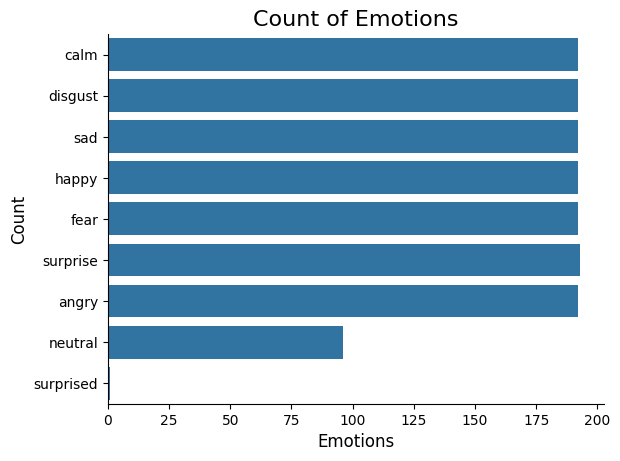

In [ ]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [ ]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr) # Use waveshow instead
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

In [ ]:
emotion='fear'
path = np.array(data_path.Path[Ravdess_df.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)


In [ ]:
emotion='angry'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

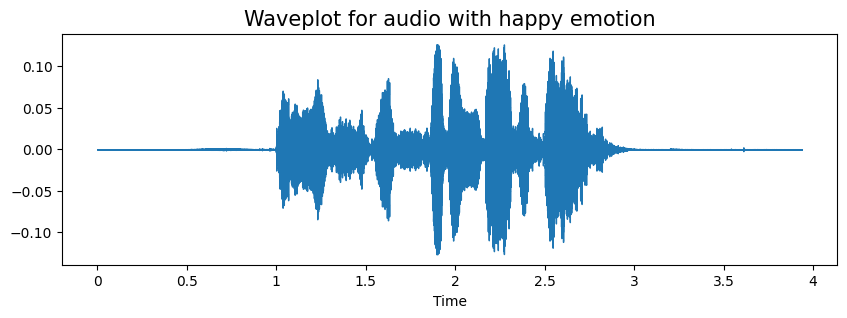

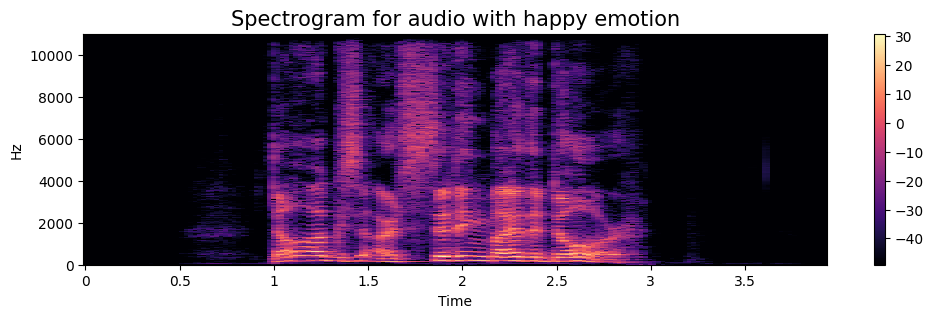

In [ ]:
emotion='happy'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

Data Augmentation

In [ ]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data
def stretch(data, rate=0.8):
    # Pass 'rate' as a keyword argument
    return librosa.effects.time_stretch(data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

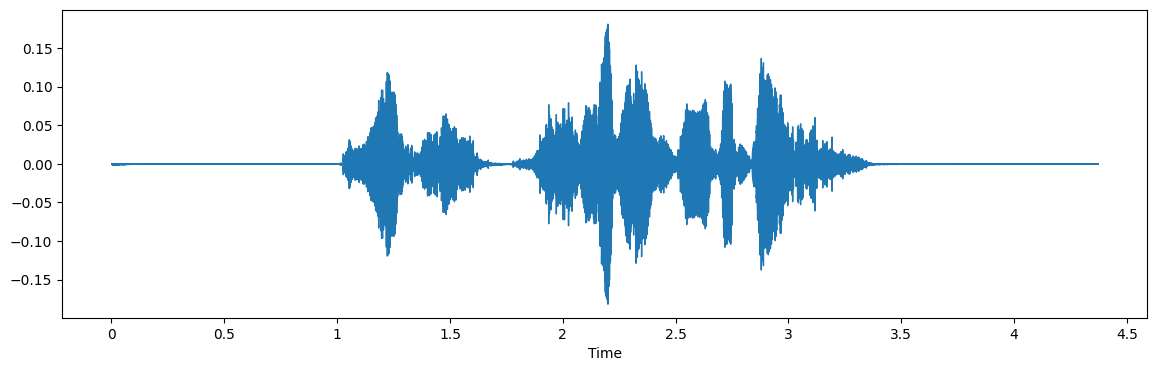

In [ ]:

plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

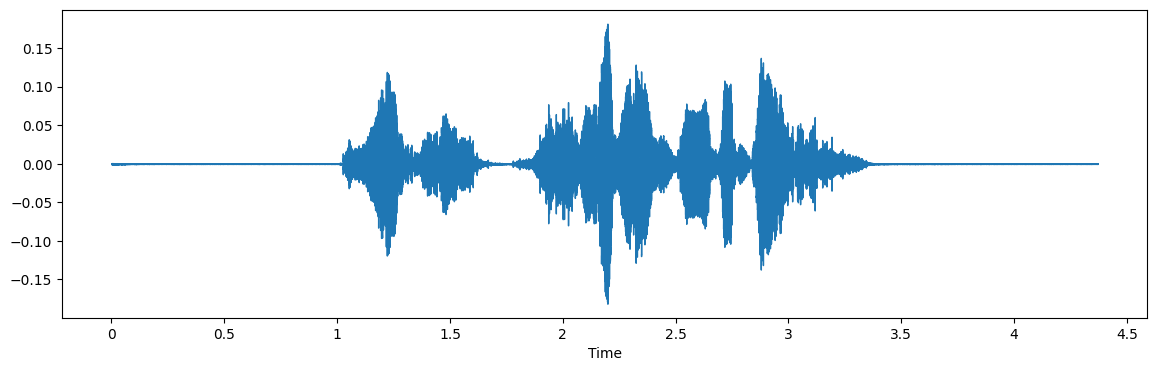

In [ ]:

x = noise(data)
plt.figure(figsize=(14,4))
# Replace waveplot with waveshow
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

In [ ]:
def stretch(data, rate=0.8):
    # Pass 'rate' as a keyword argument
    return librosa.effects.time_stretch(data, rate=rate)

Feature Extraction

In [ ]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr))

    # # Chroma_stft
    # stft = np.abs(librosa.stft(data))
    # chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    # result = np.hstack((result, chroma_stft))

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc))

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel))

    return result

def get_features(path):

    if os.path.isdir(path):
        for filename in os.listdir(path):

            file_path = os.path.join(path, filename)

            # Check if the file is an audio file (add more extensions if needed)
            if filename.endswith(('.wav', '.mp3')):
                # Load the audio file
                data, sample_rate = librosa.load(file_path, duration=2.5, offset=0.6)


                res1 = extract_features(data)
                result = np.array(res1)


                noise_data = noise(data)
                res2 = extract_features(noise_data)
                result = np.vstack((result, res2))

                # data with stretching and pitching
                new_data = stretch(data)
                data_stretch_pitch = pitch(new_data, sample_rate)
                res3 = extract_features(data_stretch_pitch)
                result = np.vstack((result, res3)) # stacking vertically

                features.extend(result)  # Add features for the current file
        return np.array(features)  # Return features for all files in the directory

    else:
        # If it's not a directory, treat it as a single audio file
        data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
        # Extract features for the single file
        result = extract_features(data)  # Assign result here

        # data with noise
        noise_data = noise(data)
        res2 = extract_features(noise_data)
        result = np.vstack((result, res2)) # stacking vertically

        # data with stretching and pitching
        new_data = stretch(data)
        data_stretch_pitch = pitch(new_data, sample_rate)
        res3 = extract_features(data_stretch_pitch)
        result = np.vstack((result, res3)) # stacking vertically

        return result  # Return features for the single file

In [ ]:
def pitch(data, sampling_rate, pitch_factor=0.7):

    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=pitch_factor)
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)

        Y.append(emotion)

In [ ]:
len(X), len(Y), data_path.Path.shape

(12720, 12720, (1455,))

In [ ]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,152,153,154,155,156,157,158,159,160,labels
0,0.258500,0.611023,0.697835,0.729005,0.690473,0.664096,0.656875,0.630116,0.668770,0.673900,...,5.800256e-06,0.000004,1.173354e-05,0.000006,0.000004,4.761126e-06,5.392429e-06,3.495796e-06,2.749969e-07,calm
1,0.248847,0.658637,0.733564,0.760495,0.742943,0.722878,0.664826,0.641793,0.690266,0.713779,...,7.420567e-06,0.000006,1.303007e-05,0.000007,0.000005,6.105417e-06,7.021041e-06,5.069395e-06,1.746893e-06,calm
2,0.156156,0.601892,0.590374,0.693287,0.719245,0.651381,0.644797,0.681689,0.644324,0.646204,...,7.612637e-07,0.000001,7.617785e-07,0.000001,0.000003,8.302436e-07,7.823006e-07,6.231139e-07,5.511275e-08,calm
3,0.239891,0.588091,0.628397,0.641703,0.630255,0.581188,0.560286,0.568445,0.613249,0.650911,...,5.792978e-03,0.004569,3.708086e-03,0.004908,0.004612,2.323000e-03,1.549064e-03,1.132992e-03,9.906103e-05,disgust
4,0.264648,0.626464,0.673201,0.695563,0.694412,0.663800,0.620365,0.580590,0.611710,0.656603,...,6.605297e-03,0.005282,4.495383e-03,0.005724,0.005426,3.053783e-03,2.267744e-03,1.754165e-03,8.034542e-04,disgust


# Data Preparation
Normalize the data and split data for training and testing

In [ ]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [ ]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
Y = encoder.fit_transform(np.array(Y))

# Get the number of unique classes
num_classes = len(encoder.classes_)
if np.any(Y >= num_classes):
    print(f"Warning: Labels found exceeding the valid range [0, {num_classes - 1}]. Clipping labels.")
    Y = np.clip(Y, 0, num_classes - 1)


In [ ]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((9540, 161), (9540,), (3180, 161), (3180,))

In [ ]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((9540, 161, 1), (9540,), (3180, 161, 1), (3180,))

Model Training and Testing

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2


encoder = LabelEncoder()
Y = encoder.fit_transform(np.array(Y))

num_classes = len(encoder.classes_)


if np.any(Y >= num_classes):
    print(f"Warning: Labels found exceeding the valid range [0, {num_classes - 1}]. Clipping labels.")
    Y = np.clip(Y, 0, num_classes - 1)


x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True, stratify=Y)

x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)

# Building the model
model = Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))
model.add(Dropout(0.3))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

# Adding L2 regularization and changing dropout rate
model.add(Flatten())
model.add(Dense(units=64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.4))


model.add(Dense(units=num_classes, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()


rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=1, patience=3, min_lr=0.0000001)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


history = model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test),
                    callbacks=[rlrp, early_stopping])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_12 (Conv1D)                   │ (None, 162, 256)            │           1,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_12 (MaxPooling1D)      │ (None, 81, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_13 (Conv1D)                   │ (None, 81, 256)             │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_13 (MaxPooling1D)      │ (None, 41, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_14 (Conv1D)                   │ (None, 41, 128)             │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_14 (MaxPooling1D)      │ (None, 21, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 21, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_15 (Conv1D)                   │ (None, 21, 64)              │          41,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_15 (MaxPooling1D)      │ (None, 11, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 704)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │          45,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 9)                   │             585 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 580,169 (2.21 MB)

 Trainable params: 580,169 (2.21 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 71s 447ms/step - accuracy: 0.4490 - loss: 4.6190 - val_accuracy: 0.6220 - val_loss: 1.5017 - learning_rate: 0.0010
Epoch 2/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 66s 441ms/step - accuracy: 0.6102 - loss: 1.6592 - val_accuracy: 0.6318 - val_loss: 1.2488 - learning_rate: 0.0010
Epoch 3/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 66s 442ms/step - accuracy: 0.6225 - loss: 1.3383 - val_accuracy: 0.6657 - val_loss: 1.1162 - learning_rate: 0.0010
Epoch 4/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 82s 444ms/step - accuracy: 0.6503 - loss: 1.1457 - val_accuracy: 0.6921 - val_loss: 1.0637 - learning_rate: 0.0010
Epoch 5/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 82s 447ms/step - accuracy: 0.6672 - loss: 1.0678 - val_accuracy: 0.7201 - val_loss: 0.9472 - learning_rate: 0.0010
Epoch 6/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 81s 443ms/step - accuracy: 0.6982 - loss: 0.9934 - val_accuracy: 0.7195 - val_loss: 0.9566 - learning_rate: 0.0010
Epoch 7/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 66s 440ms/step - accuracy: 0.7

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8407 - loss: 0.4536
Accuracy of our model on test data :  83.27044248580933 %


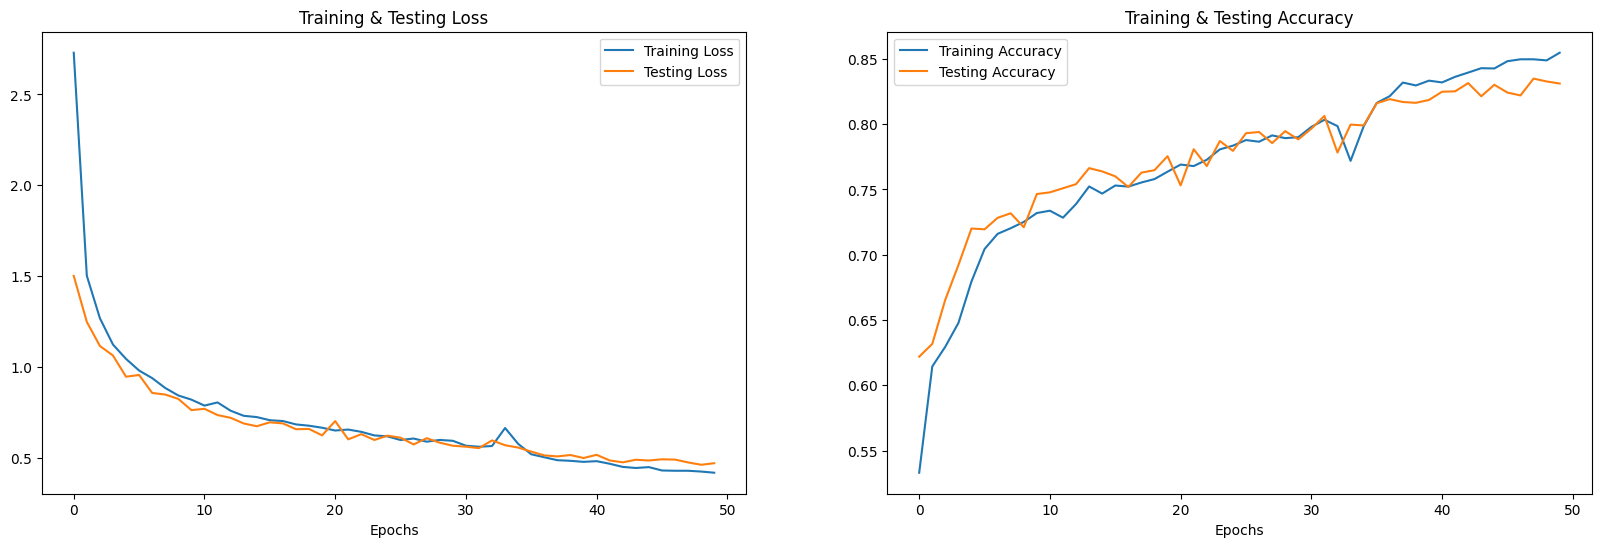

In [ ]:
import matplotlib.pyplot as plt

print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

# Adjust epochs to match the length of training history
epochs = [i for i in range(len(history.history['loss']))]  # Use len(history.history['loss']) to get correct number of epochs

fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:

import librosa

def preprocess_audio(file_path, target_shape):
    audio, sample_rate = librosa.load(file_path, sr=None)

    if len(audio) < target_shape[0]:
        audio = np.pad(audio, (0, max(0, target_shape[0] - len(audio))), mode='constant')
    else:
        audio = audio[:target_shape[0]]

    # Reshape for model input
    audio = np.expand_dims(audio, axis=0)
    audio = np.expand_dims(audio, axis=2)

    return audio

file_path = '/content/drive/MyDrive/All_audio/03-01-04-02-01-02-20.wav'
input_data = preprocess_audio(file_path, target_shape=(x_train.shape[1], 1))


In [ ]:
# Predict the emotion
prediction = model.predict(input_data)
predicted_label = np.argmax(prediction)

emotion = encoder.inverse_transform([predicted_label])
print(f"The predicted emotion is: {emotion[0]}")


In [ ]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = np.argmax(pred_test, axis=1)
y_pred = encoder.inverse_transform(y_pred)

y_test = encoder.inverse_transform(y_test)

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step


In [ ]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
# Use encoder.classes_ instead of encoder.categories_
cm = pd.DataFrame(cm , index = [i for i in encoder.classes_] , columns = [i for i in encoder.classes_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))